In [9]:
import os, sys, time, math, numpy, torch, matplotlib.pyplot

sys.path.append(os.path.abspath(os.path.join('..')))  # Allow repository modules to be imported

# Linear data

In [10]:
from settings.noisy_xor import get_dataloader

data_setting = {
    'seed': 12345,
    'input_dimension': 2, 
    'sample_size': 5000,  
    'batch_size': 5000, 
    'noise_rate': 0.,
    'within_cluster_variance': 1. / 50.,
    'clusters_per_class': 1, 
    'margin': 1.
}

data, rotation_matrix = get_dataloader(**data_setting)
_, (inputs, labels) = next(enumerate(data))

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels)

In [11]:
model_setting = {
    'epochs': 10000,
    'learning_rate': 0.05,
    'batch_size': data_setting['sample_size'],
    'initial_hidden_units': 1,
    'bias': True,
    'initialization_variance': 1. / data_setting['input_dimension'] ** 1.2
}


class GrowingTwoLayerNeuralNet(torch.nn.Module):

    def __init__(self, input_dimension:int, learning_rate:float=0., margin:float=0., noise_rate:float=0., input_domain_radious:float=1.,
                 initial_hidden_units:int=1, initial_depth:int=1, bias:bool=True, width_grow_factor:int=1, *args, **kwargs):
        super(GrowingTwoLayerNeuralNet, self).__init__()

        self.device = 'cpu'
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        self.margin = margin
        self.noise_rate = noise_rate
        self.input_domain_radious = input_domain_radious
        self.bias = bias
        self.width_grow_factor = width_grow_factor
        self.layers = [torch.nn.Linear(input_dimension if layer_index == 0 else initial_hidden_units, initial_hidden_units, bias=bias) 
                       for layer_index in range(initial_depth)]
        self.activation_function = torch.nn.ReLU()
        self.output_layer_weights = torch.tensor(([1. / initial_hidden_units ** 0.5] * math.ceil(initial_hidden_units / 2.) + 
                                                  [-1. / initial_hidden_units ** 0.5] * (initial_hidden_units // 2)))

    def parameters(self):
        parameters = []
        for layer in self.layers: parameters += list(layer.parameters())
        return parameters
        
    def forward(self, x):
        x = x.requires_grad_()
        x.retain_grad()
        self.pre_activations = []
        self.activations = []
        for layer in self.layers:
            pre_activation = layer(x).requires_grad_()
            pre_activation.retain_grad()
            self.pre_activations.append(pre_activation)
            activation = self.activation_function(pre_activation).requires_grad_()
            activation.retain_grad()
            self.activations.append(activation)
            x = activation
            
        output = torch.matmul(activation, self.output_layer_weights).unsqueeze(1)
        return output

    def to(self, device):
        super().to(device)
        for layer_index, layer in enumerate(self.layers):
            self.layers[layer_index] = layer.to(device)

        self.output_layer_weights = self.output_layer_weights.to(device)
        self.device = device
        return self

    @property
    def layer_average_gradient_norm_lower_bound(self):
        return (
            self.learning_rate * self.margin *                                # minimum possible gradient
            math.exp(- self.margin / 2. * 2. * self.input_domain_radious) / 
            (math.sqrt(2. * math.pi) * 2. * self.input_domain_radious)        # minimum possible probability of overshooting
        )

    def should_grow_layer_width(self, layer):
        layer_average_gradient_norm = self.layers[layer].weight.grad.mean(dim=0).norm().item()  # || E[ ∂L/∂w ] ||
        return layer_average_gradient_norm < self.layer_average_gradient_norm_lower_bound

    def grow_width(self, layer):
        former_weights = self.layers[layer].weight.data.clone()
        input_dimension = former_weights.shape[1]
        former_hidden_units = former_weights.shape[0]
        next_layer_weights = self.layers[layer].weight.data.clone()
        next_layer_hidden_units = self.layers[layer + 1].weight.shape[0]
        next_layer_new_weights = torch.cat([next_layer_weights, torch.zeros(next_layer_hidden_units)])
        self.layers[layer] = torch.nn.Linear(input_dimension, former_hidden_units + self.width_grow_factor, 
                                                bias=self.bias)
        self.layers[layer + 1] = torch.nn.Linear(former_hidden_units + self.width_grow_factor, 
                                                    next_layer_hidden_units, bias=self.bias)
        with torch.no_grad():
            self.layers[layer].weight[:former_hidden_units].copy_(former_weights)
            self.layers[layer + 1].weight.copy_(next_layer_new_weights)

    def layer_gradients_average_norm_upper_bound(self, layer):
        layer_average_gradient_norm = self.pre_activations[layer].grad.mean(dim=0).norm().item()  # || E[ ∂L/∂w ] ||
        return layer_average_gradient_norm * (1. + (2 *                             # maximum possible discrepancy of labels
                                                    2 * self.input_domain_radious * # maximum possible correlation with weight vector
                                                    (self.learning_rate +           # account for overshoting 
                                                     self.noise_rate)))             # account for noisy samples

    def should_grow_layer_depth(self, layer):
        layer_gradients_average_norm = self.pre_activations[layer].grad.norm(dim=1).mean().item()  # E[ || ∂L/∂w || ]
        return layer_gradients_average_norm > self.layer_gradients_average_norm_upper_bound(self, layer)

    def grow_depth(self, layer):
        hidden_units = self.layers[layer].weight.shape[1]
        next_layer_hidden_units = self.layers[layer + 1].weight.shape[0]
        self.layers.insert(layer + 1, torch.nn.Linear(hidden_units, next_layer_hidden_units, self.bias))

    def grow(self):
        for layer in range(len(self.layer)):
            if self.should_grow_layer_width(layer):
                self.grow_width(layer); return
            
        for layer in list(reversed(range(len(self.layer)))):
            if self.should_grow_layer_width(layer):
                self.grow_width(layer); return


In [12]:
import ipycanvas

training_canvas, gradients_norms_canvas, input_domain_canvas = ipycanvas.Canvas(), ipycanvas.Canvas(), ipycanvas.Canvas()
training_canvas.width = training_canvas.height = 800
gradients_norms_canvas.width = 1200; gradients_norms_canvas.height = 600
input_domain_canvas.width = input_domain_canvas.height = 800
training_canvas.font = gradients_norms_canvas.font = input_domain_canvas.font = "30px arial"
args = ('Results will appear as processed', training_canvas.width / 4, training_canvas.height / 3)
training_canvas.fill_text(*args); gradients_norms_canvas.fill_text(*args); input_domain_canvas.fill_text(*args)

In [13]:
training_canvas

Canvas(height=800, width=800)

In [14]:
gradients_norms_canvas

Canvas(height=600, width=1200)

In [15]:
input_domain_canvas

Canvas(height=800, width=800)

In [16]:
from utils.optimization import initialize, train, test, Accuracy
from plots import plot_experiment, plot_gradients_norms, plot_samples_and_model_activation_and_neurons_hyperplanes

plots_epochs_interval = 100

experiment = {
    **data_setting,
    **model_setting,
    'train': 'Accuracy',
    'test': 'Accuracy',
    'train_time': 'seconds',
    'models_runs': []
}

device = initialize(experiment['seed'])
train_data, rotation_matrix = get_dataloader(**experiment) 
test_data = get_dataloader(**experiment, rotation_matrix=rotation_matrix)
model = GrowingTwoLayerNeuralNet(**experiment).to(device)
train_loss, test_loss = torch.nn.BCEWithLogitsLoss(), Accuracy
optimizer = torch.optim.SGD(model.parameters(), lr=experiment['learning_rate'])
run = {
    'distinction': '1',
    'train': [test(train_data, model, test_loss, device)],
    'train_time': [0],
    'test': [test(test_data, model, test_loss, device, verbose=False)]
}
experiment['models_runs'].append(run)

def gradients_summary(model, *args, epoch_frequency=1):
    epoch = len(run.get('train', []))
    if epoch == 0 or epoch % epoch_frequency != 0: return

    pre_activations_gradients_average_norm = []
    pre_activations_average_gradient_norm = []
    layer_average_gradient_norm_lower_bound = []
    layer_gradients_average_norm_upper_bound = []
    for layer, pre_activations in enumerate(model.pre_activations):
        pre_activations_gradients_average_norm.append(pre_activations.grad.norm(dim=1).mean().item())
        pre_activations_average_gradient_norm.append(pre_activations.grad.mean(dim=0).norm().item())
        layer_average_gradient_norm_lower_bound.append(model.layer_average_gradient_norm_lower_bound)
        layer_gradients_average_norm_upper_bound.append(model.layer_gradients_average_norm_upper_bound(layer))

    for field in ('pre_activations_gradients_average_norm', 'pre_activations_average_gradient_norm',
                  'layer_average_gradient_norm_lower_bound', 'layer_gradients_average_norm_upper_bound'):
        if field not in run: run[field] = []
    run['pre_activations_gradients_average_norm'].append(pre_activations_gradients_average_norm)
    run['pre_activations_average_gradient_norm'].append(pre_activations_average_gradient_norm)
    run['layer_average_gradient_norm_lower_bound'].append(layer_average_gradient_norm_lower_bound)
    run['layer_gradients_average_norm_upper_bound'].append(layer_gradients_average_norm_upper_bound)
        
plot_samples_and_model_activation_and_neurons_hyperplanes(dataloader=train_data, model=model, rotation_matrix=rotation_matrix, 
                                                          **experiment, canvas=input_domain_canvas)

for epoch in range(1, experiment['epochs'] + 1):
    start_time = time.time()
    train(train_data, model, train_loss, optimizer, device, verbose=False, callback=gradients_summary)
    end_time = time.time()
    train_time = run['train_time'][-1] + end_time - start_time
    train_loss_value = test(train_data, model, test_loss, device, verbose=False)
    test_loss_value = test(test_data, model, test_loss, device, verbose=False)
    run['train'].append(train_loss_value)
    run['train_time'].append(train_time)
    run['test'].append(test_loss_value)
    if epoch % plots_epochs_interval == 0 or epoch == experiment['epochs']:
        plot_experiment(experiment, training_canvas)
        plot_gradients_norms(run, canvas=gradients_norms_canvas)
        plot_samples_and_model_activation_and_neurons_hyperplanes(
            dataloader=train_data, model=model, rotation_matrix=rotation_matrix, **experiment, 
            canvas=input_domain_canvas
        )


/Users/LePalma/Documents/git/nns_growth/notebooks/utils/plotting.py:184: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  iterations_train_ax.set_ylim(train_y_lim_min, train_y_lim_max)
/Users/LePalma/Documents/git/nns_growth/notebooks/utils/plotting.py:185: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  iterations_test_ax.set_ylim(test_y_lim_min, test_y_lim_max)
/Users/LePalma/Documents/git/nns_growth/notebooks/utils/plotting.py:189: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  time_train_ax.set_ylim(train_y_lim_min, train_y_lim_max)
/Users/LePalma/Documents/git/nns_growth/notebooks/utils/plotting.py:190: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  time_test_ax.set_ylim(test_y_lim_min, test_y_lim_max)


KeyboardInterrupt: 

/var/folders/tw/j68gkt955z57h83crjdjjrg80000gr/T/ipykernel_38719/628336771.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.pyplot.cm.get_cmap('tab10', len(model.pre_activations))


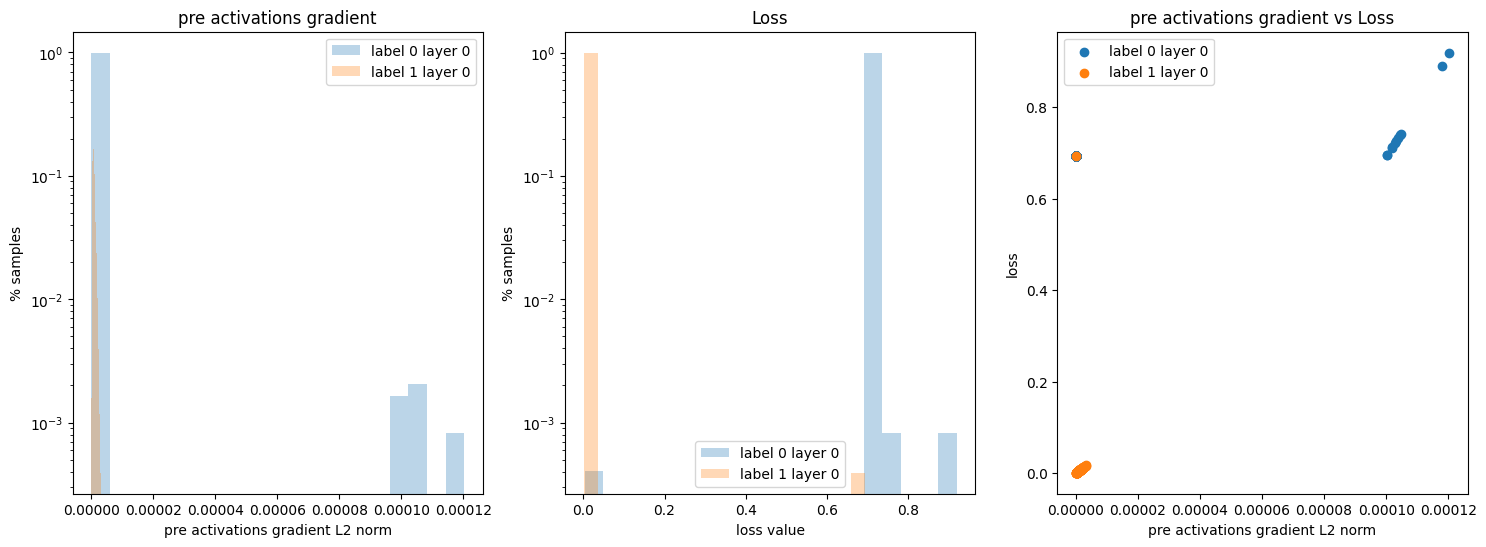

In [38]:
histogram_resolution = 20

_, (inputs, labels) = next(enumerate(train_data))
inputs, labels = inputs.to(model.device), labels.to(model.device)
predictions = model(inputs)
per_sample_loss = torch.nn.BCEWithLogitsLoss(reduction='none')(predictions, labels)
train_loss(predictions, labels).backward()

def histogram_bars(histogram_frequencies, histogram_bins):
    histogram_bins = histogram_bins.detach().cpu().numpy()[:-1]
    histogram_bins_pace = histogram_bins[1] - histogram_bins[0]
    histogram_bins += histogram_bins_pace / 2.
    histogram_frequencies = histogram_frequencies.detach().cpu().numpy()
    return histogram_bins, histogram_frequencies / histogram_frequencies.sum(), histogram_bins_pace

fig, (pre_activations_ax, loss_ax, scatter_ax) = matplotlib.pyplot.subplots(1, 3, figsize=(18, 6))

pre_activations_ax.set_title('pre activations gradient')
pre_activations_ax.set_xlabel('pre activations gradient L2 norm')
pre_activations_ax.set_ylabel('% samples')

loss_ax.set_title('Loss')
loss_ax.set_xlabel('loss value')
loss_ax.set_ylabel('% samples')

scatter_ax.set_title('pre activations gradient vs Loss')
scatter_ax.set_xlabel('pre activations gradient L2 norm')
scatter_ax.set_ylabel('loss')

colors = matplotlib.pyplot.cm.get_cmap('tab10', len(model.pre_activations))
for layer in range(len(model.pre_activations)):
    color = colors(layer)
    for label in [0, 1]:
        per_sample_grad_norm = model.pre_activations[layer].grad.norm(dim=1).unsqueeze(1)
        pre_activations_ax.bar(*histogram_bars(*torch.histogram(per_sample_grad_norm[labels==label], histogram_resolution)), label=f'label {label} layer {layer}', alpha=0.3)
        loss_ax.bar(*histogram_bars(*torch.histogram(per_sample_loss[labels==label], histogram_resolution)), label=f'label {label} layer {layer}', alpha=0.3)
        scatter_ax.scatter(per_sample_grad_norm[labels==label].cpu().detach().numpy(), per_sample_loss[labels==label].cpu().detach().numpy(), label=f'label {label} layer {layer}')

for ax in (pre_activations_ax, loss_ax, scatter_ax): ax.legend()
for ax in (pre_activations_ax, loss_ax): ax.set_yscale('log')
fig

In [41]:
inputs[per_sample_loss[labels==1].argmin()]

tensor([ 0.5269, -0.8529], device='mps:0', grad_fn=<SelectBackward0>)

In [48]:
.shape

torch.Size([5000, 2])

In [46]:
inputs.shape

torch.Size([5000, 2])

In [53]:
torch.concatenate([(labels==1),] *2, dim=1).shape

torch.Size([5000, 2])

In [59]:
inputs[torch.where(labels==1)]

tensor([-0.4718,  0.6242,  0.3505,  ...,  0.6301,  0.5721,  0.4148],
       device='mps:0', grad_fn=<IndexBackward0>)

In [34]:
data.shape

torch.Size([5000, 2])

In [26]:
model.pre_activations[layer].grad.norm(dim=1).unsqueeze(1).shape, per_sample_loss.shape

(torch.Size([5000, 1]), torch.Size([5000, 1]))